# Exercise 15 - Geometric Transformations and Image Features

Do an example with arbitrary data similar to the banknote recognition we solved and send the code along with the images.

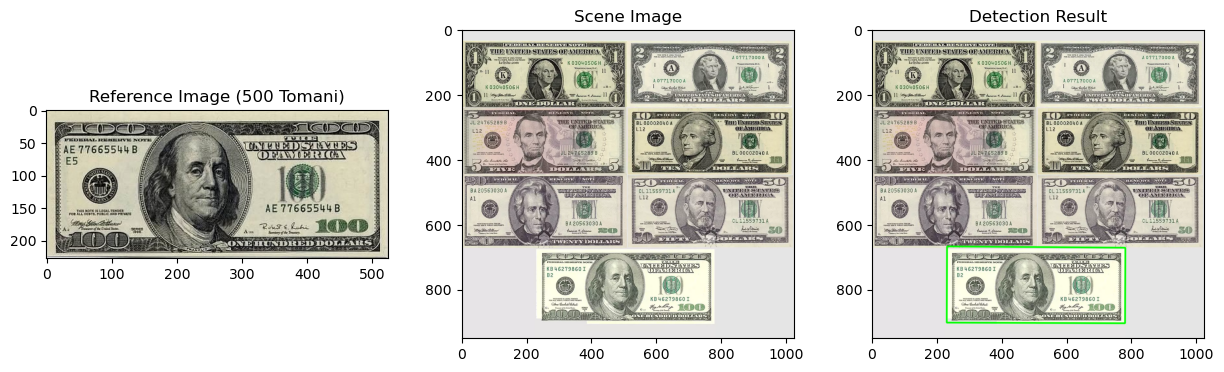

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# بارگذاری تصاویر
original_img1 = cv2.imread('D:/exam/100dollars.jpg')  # تصویر مرجع (اسکناس)
original_img2 = cv2.imread('D:/exam/scenedollars.jpg')      # تصویر صحنه
result = original_img2.copy()  # کپی برای رسم نتیجه

# تبدیل تصاویر به مقیاس خاکستری
img1 = cv2.cvtColor(original_img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(original_img2, cv2.COLOR_BGR2GRAY)

# ایجاد شیء SIFT برای استخراج نقاط کلیدی و توصیف‌گرها
sift = cv2.SIFT_create()

# یافتن نقاط کلیدی و توصیف‌گرها
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# تنظیم پارامترهای FLANN برای تطبیق نقاط
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# تطبیق نقاط با استفاده از FLANN
matches = flann.knnMatch(des1, des2, k=2)

# اعمال تست نسبت Lowe برای انتخاب تطبیق‌های خوب
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

# حداقل تعداد تطبیق‌های مورد نیاز
MIN_MATCH_COUNT = 10

# بررسی وجود تطبیق‌های کافی و محاسبه Homography
if len(good) > MIN_MATCH_COUNT:
    # استخراج مختصات نقاط تطبیق‌یافته
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    
    # محاسبه ماتریس Homography با RANSAC
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    
    # مختصات گوشه‌های تصویر مرجع
    h, w = img1.shape
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    
    # اعمال تبدیل پرسپکتیو برای یافتن مختصات گوشه‌ها در صحنه
    dst = cv2.perspectiveTransform(pts, M)
    
    # رسم کادر سبز دور اسکناس تشخیص داده شده
    result = cv2.polylines(result, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)
else:
    print(f"Not enough matches are found - {len(good)}/{MIN_MATCH_COUNT}")
    matchesMask = None

# نمایش تصاویر
plt.figure(figsize=[15, 4])
plt.subplot(131), plt.imshow(original_img1[..., ::-1]), plt.title('Reference Image (500 Tomani)')
plt.subplot(132), plt.imshow(original_img2[..., ::-1]), plt.title('Scene Image')
plt.subplot(133), plt.imshow(result[..., ::-1]), plt.title('Detection Result')
plt.show()